In [1]:
from pathlib import Path
from IPython.display import Image

from data_utils import load_import_params, load_results, get_sample_based_scores
from eval import calculate_cf_matrix, plot_cf_matrix, plot_ovr_frr_dr, get_y_true_and_y_pred_for_cf_matrix, get_y_true_roc_and_y_good_score_for_roc_curve
import yaml
import pandas as pd

# Load data

In [2]:
# import parameters
params_path = Path('./params_C51_W1.yml')
import_params = load_import_params(params_path, 'import_params')
export_params = load_import_params(params_path, 'export_params')

# import results.txt file and extract information from file names 
df_results_image_based = load_results(import_params.import_file_path, import_params)
df_results_image_based

,image_name,category,sample,revolution,trigger,truth,bad,good
0,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,50,9,9,good,0.001523,0.998477
1,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,46,3,2,good,0.202282,0.797718
2,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,58,7,10,good,0.006435,0.993565
3,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,33,3,2,good,0.004466,0.995534
4,/data/test/bad/friction_cake_bad_Image_Sidewal...,friction_cake,20,3,9,bad,1.000000,0.000000
...,...,...,...,...,...,...,...,...
2250,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,50,10,3,good,0.005667,0.994333
2251,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,5,6,7,good,0.024506,0.975494
2252,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,37,5,6,good,0.010245,0.989755
2253,/data/test/good/friction_cake_good_Image_Sidew...,friction_cake,51,3,8,good,0.014040,0.985960


# Filter categories and save data frame

In [3]:
# # filter relevant categories
# include_categories = [
#     'Airline',
#     'Verformt',
#     'BeschStopfen_',
#     'MarkStopfen_',
#     'PartikelIglo_',
#     'FaserStopfen',
#     'LyoStopfen',
#     'Gut'
# ]
# df_results_image_based = df_results_image_based[df_results_image_based.category.isin(include_categories)]

# save new data frame to csv file
export_path = Path(export_params.export_path)
path_image_based_csv = export_path / 'image_based_scores.csv'
df_results_image_based.to_csv(path_image_based_csv)

# Image-based evaluation

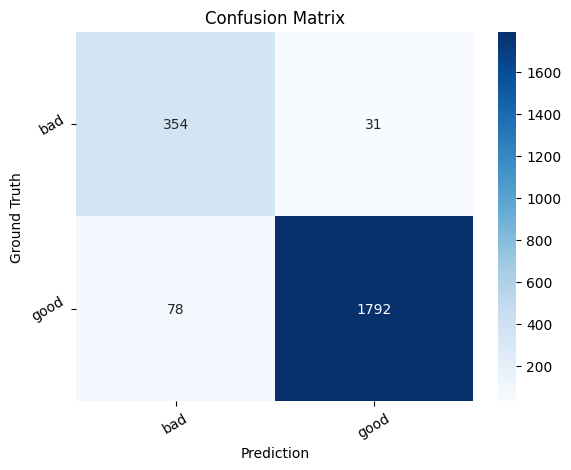

In [4]:
# Calculate prediction array (= y_pred). Prediction is the highest class score.
scores = df_results_image_based[import_params.model_classes]
truth = df_results_image_based.truth
y_true, y_pred = get_y_true_and_y_pred_for_cf_matrix(scores, truth, import_params)

# creating confusion matrix
cf_matrix = calculate_cf_matrix(y_true, y_pred, import_params)

# plotting and saving confusion matrix
save_path_cf_matrix = export_path / 'image_based_cf_matrix.png'
plot_cf_matrix(cf_matrix, save_path_cf_matrix, import_params.model_classes)

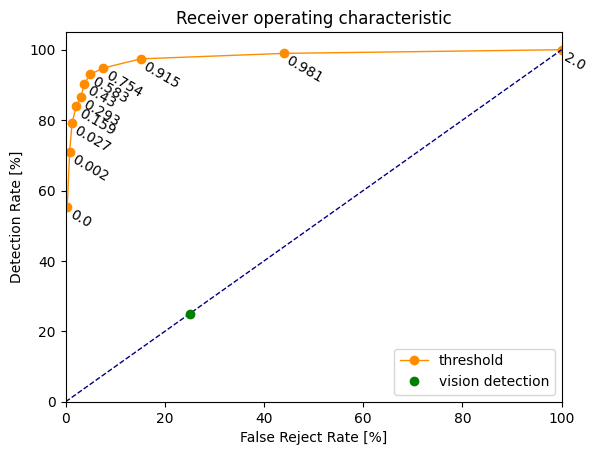

In [5]:
# converting truth to binary and calculate maximum negative score for ROC curve
y_true_roc, y_good_score = get_y_true_roc_and_y_good_score_for_roc_curve(df_results_image_based, import_params)

# plotting and saving ROC curve
save_path_ROC_curve = export_path / 'image_based_ROC_curve.png'
benchmark = [25,25]
plot_ovr_frr_dr(y_true_roc, y_good_score, save_path_ROC_curve, n = 15, pos_label=import_params.pos_label, benchmark=benchmark)


# Sample-based evaluation

In [6]:
# calculate maximum scores for each sample-revolution
def get_sample_based_scores(df: pd.DataFrame, import_params):
    df =  df.groupby(['category','sample','revolution']).agg(max)
    df = df.reset_index()
    df['sample_truth'] = df.category.apply(lambda x: import_params.category_to_model_class_map[x])
    return df

df_results_sample_based = get_sample_based_scores(df_results_image_based, import_params)
df_results_sample_based

,category,sample,revolution,image_name,trigger,truth,bad,good,sample_truth
0,damage_cake,1,1,/data/test/bad/damage_cake_bad_Image_Sidewall_...,3,bad,1.000000,0.000080,bad
1,damage_cake,1,2,/data/test/bad/damage_cake_bad_Image_Sidewall_...,6,bad,1.000000,0.002080,bad
2,damage_cake,1,3,/data/test/bad/damage_cake_bad_Image_Sidewall_...,10,bad,1.000000,0.526511,bad
3,damage_cake,1,4,/data/test/bad/damage_cake_bad_Image_Sidewall_...,10,bad,1.000000,0.711895,bad
4,damage_cake,1,5,/data/test/bad/damage_cake_bad_Image_Sidewall_...,7,bad,1.000000,0.009941,bad
...,...,...,...,...,...,...,...,...,...
385,friction_cake,70,6,/data/test/good/friction_cake_good_Image_Sidew...,10,good,0.337224,0.995816,bad
386,friction_cake,70,7,/data/test/good/friction_cake_good_Image_Sidew...,10,good,0.092333,0.999070,bad
387,friction_cake,70,8,/data/test/good/friction_cake_good_Image_Sidew...,10,good,0.269726,0.994961,bad
388,friction_cake,70,9,/data/test/good/friction_cake_good_Image_Sidew...,10,good,0.322225,0.991869,bad


In [7]:
# save sample based data frame to csv file
save_path_sample_based_csv= export_path / 'sample_based_test_scores.csv'
df_results_sample_based.to_csv(save_path_sample_based_csv)

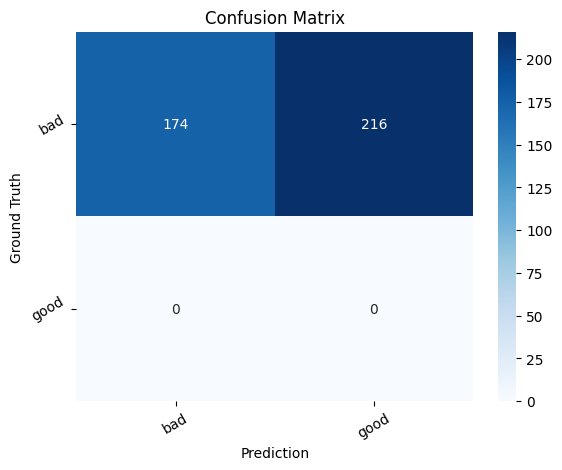

In [8]:
scores = df_results_sample_based[import_params.model_classes]
sample_truths = df_results_sample_based['sample_truth']
y_true, y_pred = get_y_true_and_y_pred_for_cf_matrix(scores, sample_truths, import_params)
cf_matrix = calculate_cf_matrix(y_true, y_pred, import_params)

# plotting and saving confusion matrix
save_path_cf_matrix = export_path / 'sample_based_cf_matrix.png'
plot_cf_matrix(cf_matrix, save_path_cf_matrix, import_params.model_classes)

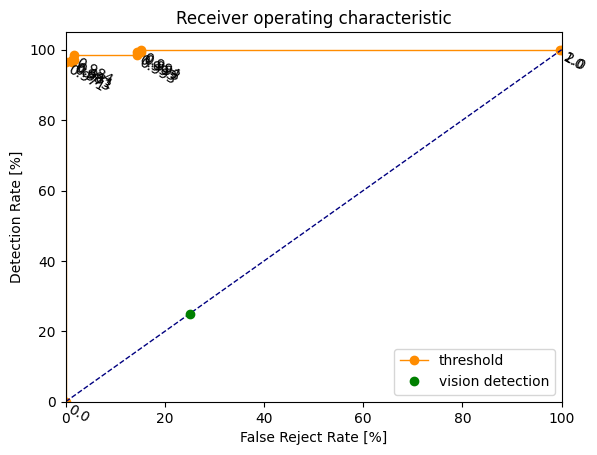

In [10]:
# converting truth to binary and calculate maximum negative score for ROC curve
y_true_roc, y_good_score = get_y_true_roc_and_y_good_score_for_roc_curve(df_results_sample_based, import_params)

# plotting and saving ROC curve
save_path_ROC_curve = export_path / 'image_based_ROC_curve.png'
benchmark = import_params.benchmark
plot_ovr_frr_dr(y_true_roc, y_good_score, save_path_ROC_curve, n = 1, pos_label=import_params.pos_label, benchmark=benchmark)